# Script to Extract Data
**Output Data:** Data for a specific variable and spatial extent  
**Description:** Downloads and extracts data for a specific variable and spatial extent and exports them to a new file.  
**Date:** June 2022, adapted for google colab July 2023    
**Authors:** Emma Perkins, Bradley Lockhart, Teagan King, Dave Bailey  

## **Mount Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


## **Install Relevant Packages**

In [ ]:
# Install packages not included in google colab
!pip install -q xarray[complete]
!pip install -q esgf-pyclient
!pip install -q h5pyd

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.5/206.5 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 41.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.0/354.0 kB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 61.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.5/18.5 MB 67.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.3/53.3 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 30.1 MB/s eta 0:00:0

In [ ]:
# Import relevant packages
import dask
import glob
import numpy as np
import os
import pandas as pd
from pyesgf.search import SearchConnection
from tqdm import tqdm
import xarray as xr

## **Download CMIP Data**

### Define Supporting Functions

In [ ]:
def create_archive_master(root_path):
  file = pd.DataFrame(columns=['Activity','Institute','Model','Experiment ID','Varient'])
  file.to_csv(os.path.join(root_path, 'Archive_Master.csv'))

def add_model(root_path, activity, institute, model, experiment_id, varient = 'r1i1p1f1'):
    model_master = pd.read_csv(root_path + 'Archive_Master.csv', index_col = 0)
    model_master.loc[len(model_master)] = pd.Series({'Activity': activity, 'Institute': institute,
                                                     'Model': model, 'Experiment ID': experiment_id, 'Varient': varient})
    model_master.to_csv(root_path + 'Archive_Master.csv')

def create_region_master(root_path):
  file = pd.DataFrame(columns = ['Region Name', 'Lat_min', 'Lat_max', 'Time_start', 'Time_stop', 'Lon_min', 'Lon_max'])
  file.to_csv(os.path.join(root_path, 'Region_Master.csv'))

def add_region(root_path, region_name, lat_min = [None], lat_max = [None], lon_min= [None], lon_max= [None], t_start= [None], t_stop= [None]):
    region_master = pd.read_csv(root_path + 'Region_Master.csv', index_col = 0)
    region_master.loc[len(region_master)] = pd.Series({'Region Name': region_name, 'Lat_min': lat_min, 'Lat_max': lat_max,
                                                       'Time_start': t_start, 'Time_stop': t_stop, 'Lon_min': lon_min, 'Lon_max': lon_max})
    region_master.to_csv(root_path+'Region_Master.csv')

def create_var_archive(region_path, variables):
  file = pd.DataFrame(columns = ['Variable', 'Table_ID', 'Complete Archive'])
  for var in np.arange(len(variables)):
    file.loc[len(file)] = pd.Series({'Variable': variables[var][0], 'Table_ID': variables[var][1], 'Complete Archive': 'False'})
  file.to_csv(region_path + 'var_archive.csv')


def check_var_archive(region_path, variable):
    # Only works if variable archive already exists
    var_archive = pd.read_csv(region_path+'var_archive.csv', index_col = 0)
    matching_rows = var_archive.loc[var_archive['Variable'] == variable[0]]
    matching_freq = matching_rows.loc[matching_rows['Table_ID']==variable[1]]
    # Variable not in archive
    if len(matching_freq) == 0:
        # Add variable to archive, return False
        new_row = pd.DataFrame({'Variable': [variable[0]], 'Table_ID': [variable[1]], 'Complete Archive': ['False']})
        var_archive = pd.concat([var_archive, new_row], ignore_index = True)
        var_archive.to_csv(region_path+'Var_archive.csv')
        return False

    elif len(matching_freq) == 1:
        complete_bool =  matching_freq.at[matching_freq.index[0],'Complete Archive'].astype(bool)
        return complete_bool
    else:
        print('Something is wrong with Variable Archive file')
        return False


def update_var_archive(region_path, variable):
    var_archive = pd.read_csv(region_path+'var_archive.csv', index_col = 0)
    matching_rows = var_archive.loc[var_archive['Variable'] == variable[0]]
    matching_freq = matching_rows.loc[matching_rows['Table_ID']==variable[1]]
    var_archive.at[matching_freq.index[0],'Complete Archive'] = 'True'
    var_archive.to_csv(region_path + 'var_archive.csv')

### Choose Location of Data Archive (root_path) and Add Specific Regions and Models

In [ ]:
# Create region and archive master files
root_path =  ''' YOUR PATH FOR DATA DOWNLOAD HERE''' # should be something like '/content/drive/MyDrive/.../'
create_archive_master(root_path)
create_region_master(root_path)

# Add regions and models of interest
add_region(root_path, 'GrIS_1990_2010', lat_min = 50, lat_max = 90, lon_min = 280, lon_max = 360, t_start = '1990-01-01', t_stop = '2010-12-31')
add_model(root_path, 'CMIP', 'NCAR', 'CESM2', 'historical')

# Print available regions and models
print("Archive Models: \n", pd.read_csv(root_path + 'Archive_Master.csv', index_col = 0))
print('Archive Regions: \n', pd.read_csv(root_path + 'Region_Master.csv', index_col = 0))

Archive Models: 
   Activity Institute  Model Experiment ID   Varient
0     CMIP      NCAR  CESM2    historical  r1i1p1f1
Archive Regions: 
       Region Name  Lat_min  Lat_max  Time_start   Time_stop  Lon_min  Lon_max
0  GrIS_1990_2010       50       90  1990-01-01  2010-12-31      280      360


### Define Path to Archive Location (Directory of Archive_Master.csv)

In [ ]:
region_master = pd.read_csv(root_path + 'Region_Master.csv', index_col = 0)
print('Available Regions (NaN = Unbounded):')
region_master

Available Regions (NaN = Unbounded):


,Region Name,Lat_min,Lat_max,Time_start,Time_stop,Lon_min,Lon_max
0,GrIS_1990_2010,50,90,1990-01-01,2010-12-31,280,360


### Choose Region and variables (with Table ID)

Be sure to use [standardized variable names](https://pcmdi.llnl.gov/mips/cmip3/variableList.html). You can find the table ID by filtering the [online database](https://esgf-node.llnl.gov/search/cmip6/) for the model, institution, variable, etc. that you are looking for.

In [ ]:
region_name = 'GrIS_1990_2010' # Select from the list above
clim_var = 'tas' # Name of CMIP variable
table_id = 'Amon' # Name of table ID for variable

In [ ]:
# Choose any variables you would like in the form [['var', 'table_id'], ...]
variables = [[clim_var, table_id]]

# Set Up Region Info + Bounds
region_master = pd.read_csv(root_path + 'Region_Master.csv', index_col = 0)
region_info = region_master.loc[region_master['Region Name'] == region_name]
if len(region_info) != 1:
    raise ValueError('Region Does not exist or Duplicate Region Names')

lat_min = region_info.at[region_info.index[0], 'Lat_min']
lat_max = region_info.at[region_info.index[0], 'Lat_max']
lon_min = region_info.at[region_info.index[0], 'Lon_min']
lon_max = region_info.at[region_info.index[0], 'Lon_max']
t_start = region_info.at[region_info.index[0], 'Time_start']
t_stop = region_info.at[region_info.index[0], 'Time_stop']

# Check for unspecified bounds
if np.isnan(lat_min):
    lat_min = -90
if np.isnan(lat_max):
    lat_max = 90
if np.isnan(lon_min):
    lon_min = 0
if np.isnan(lon_max):
    lon_max = 360
if not isinstance(t_start, str):
    t_start = None
if not isinstance(t_stop, str):
    t_stop = None

# Set esgf connection + define list of node addresses
distrib_bool = True
os.environ['ESGF_PYCLIENT_NO_FACETS_STAR_WARNING'] = '200'
conn =  SearchConnection('https://esgf-node.llnl.gov/esg-search', distrib=distrib_bool)
connections = ['https://esgf-data.dkrz.de/esg-search','https://esgf-node.llnl.gov/esg-search',
               'https://esgf.nci.org.au/esg-search', 'https://esgf-index1.ceda.ac.uk/esg-search',
               'https://esgf-node.ipsl.upmc.fr/esg-search', 'https://esg-dn1.nsc.liu.se/esg-search' ]

if not os.path.exists(root_path + 'Archive_Master.csv'):
    raise ValueError(f'Cannot find Archive_Master.csv in root path: {root_path}')

model_info = pd.read_csv(root_path + 'Archive_Master.csv', index_col = 0)

print('Ready to Download the following Variables:')
for var in variables:
    print(var)
print(f'For the region: {region_name}')
print('For the following Models:')
model_info

Ready to Download the following Variables:
['tas', 'Amon']
For the region: GrIS_1990_2010
For the following Models:


,Activity,Institute,Model,Experiment ID,Varient
0,CMIP,NCAR,CESM2,piControl,r1i1p1f1


### Download Data for the Models and Variables Listed Above to Google Drive

In [ ]:
%%time

report = []
tot_models = len(model_info['Activity'])
tot_vars = len(variables)
search_input = []

# Integer number of chunks
# If download is slow, try raising value
# If getting permission error, try lowering value
num_chunks = 36

for model_numb in tqdm(np.arange(0, tot_models)):
    model_name = model_info['Model'][model_numb]
    model_inst = model_info['Institute'][model_numb]
    model_act = model_info['Activity'][model_numb]
    model_exp = model_info['Experiment ID'][model_numb]

    #reg_path = f"{root_path}{model_act}//{model_name}//{region_name}/"
    reg_path = root_path

    # If region path exists but is lacking archive file, then archive file is created with current vars
    if not os.path.exists(root_path + 'Var_archive.csv'):
        create_var_archive(root_path, variables)

    for var_numb in np.arange(0,len(variables)):
        model_varient = model_info['Varient'][model_numb]
        var_name = variables[var_numb][0]
        var_table = variables[var_numb][1]

        # Checks completion status from archive file for given variable/frequency
        if check_var_archive(root_path, variables[var_numb]):
            report.append(tuple([model_act,model_name,model_exp, var_name, var_table, 'Existing Archive']))
            continue

        path = os.path.join(root_path, region_name)

        # Check if the directory exists
        if not os.path.exists(path):
            # Create the directory if it doesn't exist
            os.makedirs(path)

        ctx = conn.new_context(facets=None,
            #facets='project,activity_id,table_id,institution_id,experiment_id,source_id,variable,variant_label',
            #facets= '*',
            project='CMIP6',
            activity_id= model_act,
            table_id= var_table,
            institution_id= model_inst,
            experiment_id=model_exp,
            source_id= model_name,
            variable= var_name,
            variant_label= model_varient,
        )

        search_input.append(tuple([model_act, var_table, model_inst, model_exp, model_name, var_name, model_varient]))

        Found_data = False
        query_result = ctx.search()
        opendap_urls = []

        # Check for return from search query
        if np.shape(query_result)[0] == 0:
            # If no return, test different esgf nodes
            for cons in connections:
                print(f'Testing {cons}')
                conn =  SearchConnection(cons, distrib = distrib_bool)
                alt_result = ctx.search()
                if np.shape(alt_result)[0] != 0:
                    files = alt_result[0].file_context().search()
                    opendap_urls = [file.opendap_url for file in files]
                    if len(opendap_urls) != 0:
                        Found_data = True
                        break
        # Sometimes a node will return an empty search result rather than no search result
        # checks for this behavior and tries other nodes
        else:
            file_q = query_result[0]
            files = file_q.file_context().search()
            opendap_urls = [file.opendap_url for file in files]
            if opendap_urls != 0:
                Found_data = True

            else:
                print(f'Testing {cons}')
                conn =  SearchConnection(cons, distrib = distrib_bool)
                alt_result = ctx.search()
                if np.shape(alt_result)[0] != 0:
                    files = alt_result.file_context().search()
                    opendap_urls = [file.opendap_url for file in files]

                    if len(opendap_urls) != 0:
                        Found_data = True
                        break
        # After testing all nodes, if no data is found, append report and continue to next var
        if not Found_data:
            report.append(tuple([model_act,model_name,model_exp, var_name, var_table, 'Data Not Found']))
            continue

        existing_file_count = 0

        for x in range(0,len(opendap_urls)):
            # Define the name of the output file
            filename = f'{opendap_urls[x].split("/")[-1]}'
            file_exist = os.path.exists(os.path.join(path,filename))

            if not file_exist:
                # Define the path to the output file
                filepath = os.path.join(path, filename)

                # Use xarray to open the dataset from the response content
                ds = xr.open_dataset(opendap_urls[x])

                # Slice data for given region
                lat_range = np.logical_and(ds['lat'] >= lat_min, ds['lat'] <= lat_max)
                lon_range = np.logical_and(ds['lon'] >= lon_min, ds['lon'] <= lon_max)
                ds_out = ds.sel(lat = lat_range, lon = lon_range, time = slice(t_start, t_stop))

                # Close unsliced dataset to free up memory
                ds.close()

                # Current netcdf file has no data within time range
                if len(ds_out.time) == 0:
                    ds_out.close()
                    continue

                chunk_size = {'time': num_chunks}

                # Save the dataset to a netCDF file in the download directory if does not exist
                with dask.config.set(scheduler='threads'):
                    ds_out.chunk(chunk_size).to_netcdf(filepath)
                # Close the dataset to free up memory
                ds_out.close()

            if file_exist:
                existing_file_count += 1

        update_var_archive(reg_path, variables[var_numb])
        report.append(tuple([model_act,model_name,model_exp, var_name, var_table, 'Data Downloaded']))


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/xarray/backends/plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)
/usr/local/lib/python3.10/dist-packages/xarray/conventions.py:523: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/usr/local/lib/python3.10/dist-packages/xarray/conventions.py:523: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/usr/local/lib/python3.10/dist-packages/xarray/conventions.py:523: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/usr/local/lib/python3.10/dist-packages/xarray/conventions.py:523: SerializationWarning: variable 'tas' has mul

CPU times: user 1.63 s, sys: 82.4 ms, total: 1.71 s
Wall time: 24.2 s


In [ ]:
path

'/content/drive/Shareddrives/NNA-CPAD-Tutorial/Data/CMIP_data/GrIS_1990_2010'

### Display Download Report

In [ ]:
report

[('CMIP', 'CESM2', 'piControl', 'tas', 'Amon', 'Data Downloaded')]

## **Download ERA5 Data**.
Instructions on how to get your own CDS API key
[here](https://cds.climate.copernicus.eu/api-how-to)

In [ ]:
#setup the API
url = 'url: https://cds.climate.copernicus.eu/api/v2'
key = '''YOUR CDS API KEY HERE''' # replace with your key

with open('/root/.cdsapirc', 'w') as f:
    f.write('\n'.join([url, key]))

with open('/root/.cdsapirc') as f:
    print(f.read())

url: https://cds.climate.copernicus.eu/api/v2
key: 134121:adfd03b2-7d40-48c6-9960-73fdae094a0d


In [ ]:
# Install the API
!pip install cdsapi

  Preparing metadata (setup.py) ... done
  Created wheel for cdsapi: filename=cdsapi-0.6.1-py2.py3-none-any.whl size=12008 sha256=94fd659201fec8a1364eb739136963a92accccf32868fca483484e7bb68cf77b
  Stored in directory: /root/.cache/pip/wheels/7c/63/08/45461d6f6636c1aba7846828d8c787a064073945048f76d44a
Successfully built cdsapi


## Choose matching data at [Copernicus](https://cds.climate.copernicus.eu/cdsapp#!/search?type=dataset) and copy the API request.
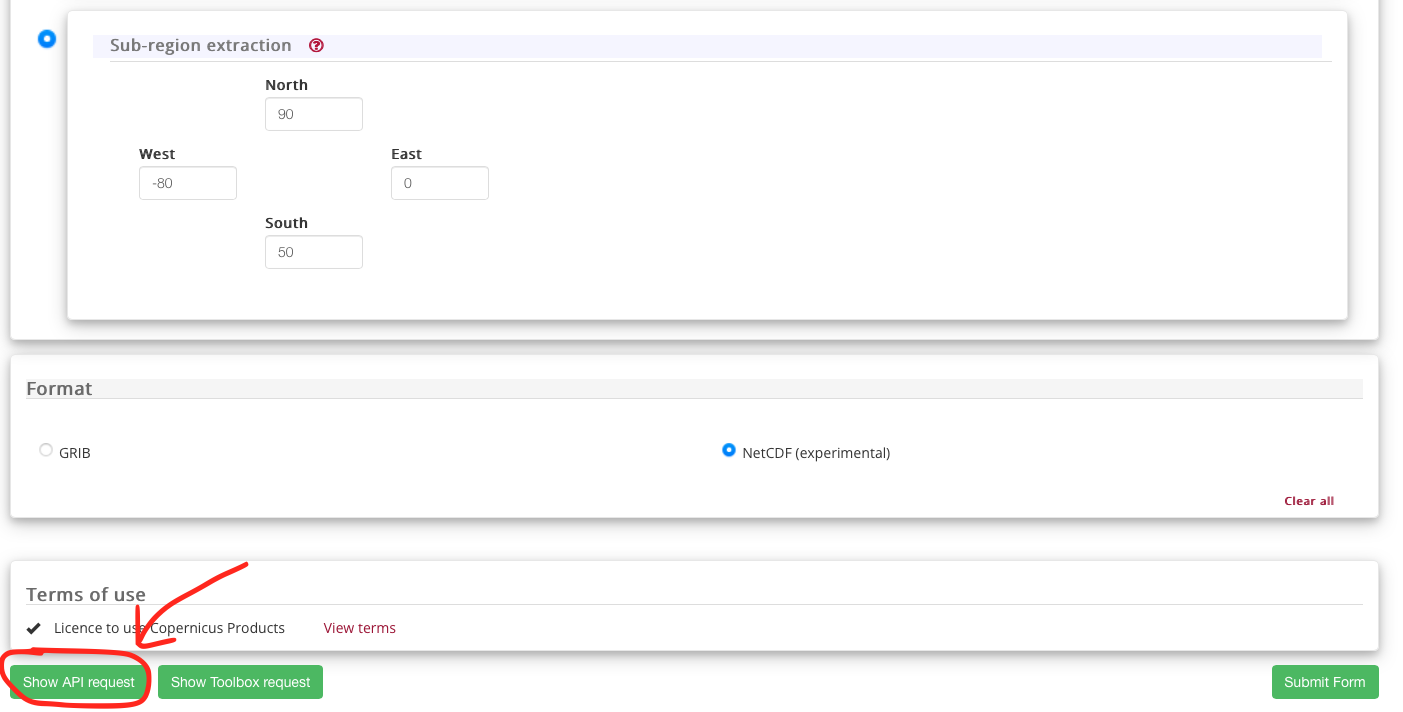

In [ ]:
era_path = ''' YOUR PATH FOR DATA DOWNLOAD HERE''' # should be something like '/content/drive/MyDrive/.../'
era_name = 'era5_skt_1990_2010_1M_GrIS.nc'
era_data = os.path.join(era_path, era_name)

import cdsapi

c = cdsapi.Client()

# Paste API request below
c.retrieve(
    'reanalysis-era5-single-levels-monthly-means',
    {
        'format': 'netcdf',
        'variable': 'skin_temperature',
        'product_type': 'monthly_averaged_reanalysis',
        'year': [
            '1990', '1991', '1992',
            '1993', '1994', '1995',
            '1996', '1997', '1998',
            '1999', '2000', '2001',
            '2002', '2003', '2004',
            '2006', '2007', '2008',
            '2009', '2010',
        ],
        'month': [
            '01', '02', '03',
            '04', '05', '06',
            '07', '08', '09',
            '10', '11', '12',
        ],
        'time': '00:00',
        'area': [
            70, 25, 65,
            30,
        ],
    },
    era_data) # Replace download.nc with era_data

2023-07-26 16:37:04,912 INFO Welcome to the CDS
INFO:cdsapi:Welcome to the CDS
2023-07-26 16:37:04,920 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels-monthly-means
INFO:cdsapi:Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels-monthly-means
2023-07-26 16:37:05,078 INFO Request is queued
INFO:cdsapi:Request is queued
2023-07-26 16:37:07,809 INFO Request is running
INFO:cdsapi:Request is running
2023-07-26 18:01:48,877 INFO Request is completed
INFO:cdsapi:Request is completed
2023-07-26 18:01:48,884 INFO Downloading https://download-0019.copernicus-climate.eu/cache-compute-0019/cache/data9/adaptor.mars.internal-1690394398.8900762-3431-10-e9e8d01a-ab92-41f4-adcc-f60855d03249.nc to /content/drive/Shareddrives/NNA-CPAD/Data/ERA_data/era5_skt_1990_2010_1M_GrIS.nc (208.9K)
INFO:cdsapi:Downloading https://download-0019.copernicus-climate.eu/cache-compute-0019/cache/data9/adaptor.mars.int

Result(content_length=213876,content_type=application/x-netcdf,location=https://download-0019.copernicus-climate.eu/cache-compute-0019/cache/data9/adaptor.mars.internal-1690394398.8900762-3431-10-e9e8d01a-ab92-41f4-adcc-f60855d03249.nc)

### **Load Full Data**

In [ ]:
# Climate data:
clim_files = glob.glob(os.path.join(path, '*'+str(clim_var)+'*.nc'))
clim_data = xr.open_mfdataset(clim_files, concat_dim=None)

# Observational data:
obs_data = xr.open_dataset(era_data)

### If you are trying to extract data for a region with a longitudinal discontinuity (ex: 150 to -170), download for all lons and downselect here:

In [ ]:
#convert ERA5 data to Long3
obs_data['longitude'] = obs_data.longitude % 360
obs_data = obs_data.sortby('longitude')

#select appropriate lon region for ERA5
lon_min = region_master[region_master['Region Name'] == region_name].Lon_min[0]
lon_max = region_master[region_master['Region Name'] == region_name].Lon_max[0]
obs_data = obs_data.sel(longitude=slice(lon_min, lon_max))

## **Select Only Variable of Interest**

In [ ]:
obs_var = 'skt'
clim_select = clim_data[clim_var] # Previously defined clim_var when downloading clim data
obs_select = obs_data[obs_var].rename(clim_var) # Rename observational data to have same variable name as climate data

## **Standardize Lat Lon Conventions**

In [ ]:
# Set variable names
obs_lat_var = 'latitude'  # Name of latitude variable for observational data
clim_lat_var = 'lat'  # Name of latitude variable for climate data
obs_lon_var = 'longitude'  # Name of longitude variable for observational data
clim_lon_var = 'lon'  # Name of longitude variable for climate model data

# Rename lat lon variables to all be lat lon
obs_select = obs_select.rename({obs_lat_var: 'lat', obs_lon_var: 'lon'})
clim_select = clim_select.rename({clim_lat_var: 'lat', clim_lon_var: 'lon'})

# Sort by latitude
obs_select = obs_select.sortby('lat')
clim_select = clim_select.sortby('lat')

obs_lon_type = 'long3'  # Observational longitude coordinate type (long1 or long3)
clim_lon_type = 'long3'  # Climate model longitude coordinate type (long1 or long3)
if clim_lon_type == 'long3':
    clim_lon_new = (clim_select.lon + 180) % 360 - 180
    clim_select['lon'] = clim_lon_new
if obs_lon_type == 'long3':
    obs_lon_new = (obs_select.lon + 180) % 360 - 180
    obs_select['lon'] = obs_lon_new
clim_data = clim_select.sortby('lon')
obs_data = obs_select.sortby('lon')

<ipython-input-21-1db3bb5d2bc1>:9: UserWarning: rename 'lat' to 'lat' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  clim_select = clim_select.rename({clim_lat_var: 'lat', clim_lon_var: 'lon'})
<ipython-input-21-1db3bb5d2bc1>:9: UserWarning: rename 'lon' to 'lon' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  clim_select = clim_select.rename({clim_lat_var: 'lat', clim_lon_var: 'lon'})


## **Export Data for Analysis**

In [ ]:
%%time
'/content/drive/Shareddrives/NNA-CPAD-Tutorial/Data/ComparisonData/'+region_name+'/'+clim_var+'clim_analysis.nc'

if not os.path.exists(os.path.join('/content/drive/Shareddrives/NNA-CPAD-Tutorial/Data/ComparisonData/', region_name)):
        os.makedirs(os.path.join('/content/drive/Shareddrives/NNA-CPAD-Tutorial/Data/ComparisonData/', region_name))
clim_data.load().to_netcdf(os.path.join('/content/drive/Shareddrives/NNA-CPAD-Tutorial/Data/ComparisonData/', region_name, model_name+'_'+model_exp+'_'+model_varient+'_'+clim_var+'.nc'))
obs_data.load().to_netcdf(os.path.join('/content/drive/Shareddrives/NNA-CPAD-Tutorial/Data/ComparisonData/', region_name, 'era5_'+obs_var+'.nc'))

CPU times: user 601 ms, sys: 245 ms, total: 846 ms
Wall time: 2.99 s
